# ****FLUSHING ANALYTICS****


# Installing Dependencies

In [788]:
# %pip install pandas
# %pip install pyproj
# %pip install scikit-learn
# %pip install openpyxl
# %pip install matplotlib
# %pip install seaborn

# Preparing the Data

## Loading and exploring the datasets

In [789]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from pyproj import Proj, transform

# file_path = '/EllaTesting/Files/Repairs_2018_2023.xlsx'

# print(file_path)

# Creating DataFrames from spreadsheets
all_hydrants_filepath = "Updated_Qry_AllHY.csv"
flushing_history_filepath = "Qry_FlushHistory.csv"

all_hydrants_df = pd.read_csv(all_hydrants_filepath)
flushing_history_df = pd.read_csv(flushing_history_filepath)

C:\Users\17561\AppData\Local\Temp\1\ipykernel_24468\3096977762.py:20: DtypeWarning: Columns (4,5,8,10,11,13,14,16,18,20,22,23,24,25,26,28,29,33,35,37,44,46,49,57,68,71,80,89,91,93) have mixed types. Specify dtype option on import or set low_memory=False.
  all_hydrants_df = pd.read_csv(all_hydrants_filepath)
C:\Users\17561\AppData\Local\Temp\1\ipykernel_24468\3096977762.py:21: DtypeWarning: Columns (0,4,5,15,23,24,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  flushing_history_df = pd.read_csv(flushing_history_filepath)


## Data Cleaning and Preprocessing

### Data Cleaning - History Table

In [790]:
# Creating a copy of the Flushing History DataFrame
copied_flushing_history_df = copy.deepcopy(flushing_history_df)

In [791]:
#delete all unnecessary columns
copied_flushing_history_df = copied_flushing_history_df.drop(columns={'FLSHTIME3', 'FLSHTIME4', 'FLSHTIME5', 'FLSHTIME6', 'FLSHTIME7', 'FLSHTIME8', 'FLSHTIME9', 'FLSHTIME10', 'FLSHTIME11', 'FLSHVOL1', 'FLSHVOL2', 'FLSHVOL3', 'FLSHVOL4', 'FLSHVOL5', 'FLSHVOL6', 'FLSHVOL7', 'FLSHVOL8', 'FLSHVOL9', 'FLSHVOL10', 'FLSHVOL11', 'CLFREE3', 
                                                                      'CLFREE4', 'CLFREE5', 'CLFREE6', 'CLFREE7', 'CLFREE8', 'CLFREE9', 'CLFREE10', 'CLFREE11', 'CLTOTL3', 'CLTOTL4', 'CLTOTL5', 'CLTOTL6', 'CLTOTL7', 'CLTOTL8', 'CLTOTL9', 'CLTOTL10', 'CLTOTL11', 'ADDBY', 'ADDDTTM', 'MODBY', 'MODDTTM', 'REMARKS', 'FLSHTIME', 'FLUSHNC', 'NFREASON',  
                                                                      'CLTOTL1', 'CLTOTL2', 'CLTOTL', 'UNSCEHDLD',  'ALTERNATE'})

In [792]:
copied_flushing_history_df.shape

(116808, 16)

In [793]:
copied_flushing_history_df = copied_flushing_history_df.dropna(subset=['FLSHFRE', 'FLSHDATE', 'CLFREE', 'PHREAD', 'FLSHVOL', 'FLSHDUR', 'COMPKEY'])

In [794]:
copied_flushing_history_df.shape

(112606, 16)

In [795]:
copied_flushing_history_df.head(10)

,INSPKEY,GRIDKEY,FLSHFRE,FLSHDATE,CLFREE,PHREAD,FLSHVOL,FLSHDUR,INSPBY,CLFREE1,CLFREE2,WWNUM,COMMUN,COMPKEY,FLSHTIME1,FLSHTIME2
6,965966,19046430,1 WEEK,2019-04-23,1.18,7.92,1.000,5.0,61535,NaN,NaN,WW220003993,CD,805425.0,NaN,NaN
7,972209,19048814,1 MONTH,2019-04-25,1.66,7.90,18.000,10.0,65673,1.67,NaN,WW220003993,CV,9876.0,15:05,NaN
8,972253,19048815,1 MONTH,2019-04-25,1.33,7.51,10.000,10.0,65673,1.30,NaN,WW260002590,CR,540642.0,09:55,NaN
9,965951,19048816,1 WEEK,2019-04-29,1.69,7.50,6.000,5.0,65673,NaN,NaN,WW260002590,CT,531455.0,NaN,NaN
10,965955,19048817,2 WEEKS,2019-04-30,1.67,7.86,10.000,10.0,65673,1.64,NaN,WW220003993,CV,541072.0,10:50,NaN
11,965950,19048818,1 WEEK,2019-04-30,0.72,8.09,23.000,15.0,65673,0.77,0.82,WW260094120,CB,528297.0,09:40,09:45
12,970581,19048819,2 WEEKS,2019-05-01,1.09,8.21,1.000,5.0,61535,NaN,NaN,WW260094120,CB,9986.0,NaN,NaN
13,970575,19048820,2 WEEKS,2019-05-01,1.11,8.31,1.000,5.0,61535,NaN,NaN,WW260094120,CCC,9263.0,NaN,NaN
14,965730,19048821,3 DAYS,2019-03-01,0.92,7.69,1.194,20.0,35832,NaN,NaN,WW260094120,B,7781.0,NaN,NaN
15,965730,19048822,3 DAYS,2019-04-30,0.42,7.89,5.000,13.0,68527,0.71,NaN,WW260094120,B,7781.0,07:40,NaN


In [796]:
# Summer months: April-Sept
# Winter months: Oct-March
copied_flushing_history_df['FLSHDATE'] = pd.to_datetime(copied_flushing_history_df['FLSHDATE'], errors='coerce')
copied_flushing_history_df['SEASON'] = copied_flushing_history_df['FLSHDATE'].dt.month
copied_flushing_history_df['SEASON'] = copied_flushing_history_df['SEASON'].replace(to_replace=[4, 5, 6, 7, 8, 9],
           value="0")
copied_flushing_history_df['SEASON'] = copied_flushing_history_df['SEASON'].replace(to_replace=[10, 11, 12, 1, 2, 3],
           value="1")
copied_flushing_history_df['SEASON']

6         0
7         0
8         0
9         0
10        0
         ..
116803    0
116804    0
116805    0
116806    0
116807    0
Name: SEASON, Length: 112606, dtype: object

In [797]:
copied_flushing_history_df['CLFREE2'] = copied_flushing_history_df['CLFREE2'].fillna(0)

In [798]:
copied_flushing_history_df['CLFREEFINAL'] = np.where(copied_flushing_history_df['CLFREE2'] > 0, copied_flushing_history_df['CLFREE2'], copied_flushing_history_df['CLFREE1'])

In [799]:
copied_flushing_history_df = copied_flushing_history_df.dropna(subset=['CLFREEFINAL'])
copied_flushing_history_df

,INSPKEY,GRIDKEY,FLSHFRE,FLSHDATE,CLFREE,PHREAD,FLSHVOL,FLSHDUR,INSPBY,CLFREE1,CLFREE2,WWNUM,COMMUN,COMPKEY,FLSHTIME1,FLSHTIME2,SEASON,CLFREEFINAL
7,972209,19048814,1 MONTH,2019-04-25,1.66,7.90,18.0,10.0,65673,1.67,0.00,WW220003993,CV,9876.0,15:05,NaN,0,1.67
8,972253,19048815,1 MONTH,2019-04-25,1.33,7.51,10.0,10.0,65673,1.30,0.00,WW260002590,CR,540642.0,09:55,NaN,0,1.30
10,965955,19048817,2 WEEKS,2019-04-30,1.67,7.86,10.0,10.0,65673,1.64,0.00,WW220003993,CV,541072.0,10:50,NaN,0,1.64
11,965950,19048818,1 WEEK,2019-04-30,0.72,8.09,23.0,15.0,65673,0.77,0.82,WW260094120,CB,528297.0,09:40,09:45,0,0.82
15,965730,19048822,3 DAYS,2019-04-30,0.42,7.89,5.0,13.0,68527,0.71,0.00,WW260094120,B,7781.0,07:40,NaN,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116802,1242027,19513855,3 DAYS,2024-04-30,1.19,7.30,5.0,15.0,17571,1.23,0.00,WW260094120,B,796912.0,11:25,NaN,0,1.23
116803,1242028,19513856,3 DAYS,2024-04-15,1.00,8.25,13.0,10.0,13394,0.98,0.00,WW260094120,CDR,798643.0,08:30,NaN,0,0.98
116805,1242029,19513858,2 DAYS,2024-05-01,0.66,7.82,26.0,20.0,13787,1.01,0.00,WW260094120,M,798849.0,09:50,NaN,0,1.01
116806,1242628,19513859,2 WEEKS,2024-05-02,1.17,7.98,20.0,15.0,68870,1.10,0.00,WW260094120,B,801724.0,13:50,NaN,0,1.10


In [800]:
# Calculating the FLSHDATE delta
copied_flushing_history_df = copied_flushing_history_df.sort_values(by=['COMPKEY', 'FLSHDATE'])

copied_flushing_history_df['FLSHDATE_DELTA'] = copied_flushing_history_df.groupby('COMPKEY')['FLSHDATE'].shift(1)  # shift CLFREEFINAL up by 1 row within each COMPKEY group

copied_flushing_history_df['FLSHDATE_DELTA'] = (copied_flushing_history_df['FLSHDATE'] - copied_flushing_history_df['FLSHDATE_DELTA']).dt.days  # calculate the difference between CLFREE and shifted CLFREEFINAL

copied_flushing_history_df

,INSPKEY,GRIDKEY,FLSHFRE,FLSHDATE,CLFREE,PHREAD,FLSHVOL,FLSHDUR,INSPBY,CLFREE1,CLFREE2,WWNUM,COMMUN,COMPKEY,FLSHTIME1,FLSHTIME2,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,750335,1826244,1 YEAR,2015-11-30,0.67,0.00,4.00,8.0,68297.0,0.81,0.0,WW260094120,B,1002.0,NaN,NaN,1,0.81,NaN
21057,820873,18494168,1 YEAR,2016-11-24,0.70,0.00,10.00,20.0,68532,0.93,0.0,WW260094120,B,1002.0,NaN,NaN,1,0.93,360.0
62794,1017213,19280486,1 YEAR,2019-12-04,0.91,8.10,2.00,14.0,68527,1.10,0.0,WW260094120,B,1002.0,13:32,NaN,1,1.10,1105.0
85374,1125503,19410183,1 YEAR,2021-11-24,0.87,8.02,12.00,15.0,15591,1.23,0.0,WW260094120,B,1002.0,10:30,NaN,1,1.23,721.0
98795,1178642,19463429,1 YEAR,2022-11-24,0.92,8.06,7.14,10.0,68739,0.96,0.0,WW260094120,B,1002.0,08:56,NaN,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116406,1253375,19515396,1 WEEK,2024-05-14,1.15,7.64,15.00,15.0,69695,1.24,0.0,WW220003993,C,1307858.0,12:50,NaN,0,1.24,7.0
115860,1253375,19515992,1 WEEK,2024-05-23,1.12,7.49,17.00,10.0,22506,1.29,0.0,WW220003993,C,1307858.0,12:49,NaN,0,1.29,9.0
115140,1253375,19517454,1 WEEK,2024-05-30,1.00,7.68,20.00,20.0,69695,1.16,0.0,WW220003993,C,1307858.0,09:00,NaN,0,1.16,7.0
115821,1253375,19517764,1 WEEK,2024-06-14,0.69,7.71,12.00,15.0,24289,0.99,0.0,WW220003993,C,1307858.0,14:00,NaN,0,0.99,15.0


In [801]:
copied_flushing_history_df = copied_flushing_history_df.drop(columns=['CLFREE1', 'CLFREE2', 'FLSHTIME1', 'FLSHTIME2', 'INSPKEY', 'GRIDKEY', 'FLSHVOL', 'FLSHDUR', 'INSPBY', 'COMMUN'])

In [802]:
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0


In [803]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['PHREAD'] > 2000].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0


In [804]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['PHREAD'] < 0].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0


In [805]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['CLFREE'] == 0].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0


In [806]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['CLFREEFINAL'] == 0].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0


In [807]:
copied_flushing_history_df['CLFREE'] = copied_flushing_history_df['CLFREE'].replace(78, 0.78)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0


In [808]:
wwnum_temp = pd.get_dummies(copied_flushing_history_df['WWNUM'])
copied_flushing_history_df = copied_flushing_history_df.join(wwnum_temp)

In [809]:
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,SEASON,CLFREEFINAL,FLSHDATE_DELTA,WW220003993,WW220004000,WW220004037,WW260002590,WW260094120
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,1,0.81,NaN,False,False,False,False,True
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,1,0.93,360.0,False,False,False,False,True
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,1,1.10,1105.0,False,False,False,False,True
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,1,1.23,721.0,False,False,False,False,True
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,1,0.96,365.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,0,1.24,7.0,True,False,False,False,False
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,0,1.29,9.0,True,False,False,False,False
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,0,1.16,7.0,True,False,False,False,False
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,0,0.99,15.0,True,False,False,False,False


In [810]:
#TODO: Ayan: Use the COMPKEY to fill out the missing values in COMMUN
# # Sorting the DataFrame by COMPKEY, as there is a pattern between COMPKEY values and COMMUN values
# copied_flushing_history_df = copied_flushing_history_df.sort_values('COMPKEY')

# # Imputing every missing value with the value that came before it in the sorted DataFrame
# copied_flushing_history_df['COMMUN'] = copied_flushing_history_df['COMMUN'].ffill()

In [811]:
# For visualizing the box and whisker plot
import seaborn as sns

# Replaces all outliers within a given column with the median of that column
def replace_outliers(df, column):
    # Creates a box and whisker plot to visualize data points that are considered to be outliers
    sns.boxplot(df[column])
    plt.title(f"Original Box and Whisker Plot for {column}")
    plt.show()
    
    # Computing the first, second (median), and third quartiles
    q1 = df[column].quantile(0.25)
    q2 = df[column].quantile(0.5)
    q3 = df[column].quantile(0.75)

    print(f"First quartile is {q1}")
    print(f"Median is {q2}")
    print(f"Third quartile is {q3}")
    
    # Computing the interquartile range
    iqr = q3 - q1

    # Values that are lower than the lower fence or higher than the upper fence are considered to be outliers
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)

    print(f"Lower fence is {lower_fence}")
    print(f"Upper fence is {upper_fence}")

    # Replace outliers with the median
    adjusted_column = [x if lower_fence <= x <= upper_fence else q2 for x in df[column]]
    
    # New box and whisker plot with outliers adjusted
    sns.boxplot(adjusted_column)
    plt.title(f"New Box and Whisker Plot for {column}")
    plt.show()

    return adjusted_column

In [812]:
# Replacing outliers in the FLSHVOL column
# copied_flushing_history_df['FLSHVOL'] = replace_outliers(copied_flushing_history_df, 'FLSHVOL')

In [813]:
# Replacing outliers in the FLSHDUR column
# copied_flushing_history_df['FLSHDUR'] = replace_outliers(copied_flushing_history_df, 'FLSHDUR')

In [814]:
# Calculates a new column representing the difference between the CLFREE reading before a flush and the CLFREEFINAL reading of the previous flush (the first flush for a given hydrant is given the value equal to the CLFREEFINAL reading of the flush)
copied_flushing_history_df = copied_flushing_history_df.sort_values(by=['COMPKEY', 'FLSHDATE'])

copied_flushing_history_df['CLDELTA'] = copied_flushing_history_df.groupby('COMPKEY')['CLFREEFINAL'].shift(1)  # shift CLFREEFINAL up by 1 row within each COMPKEY group

copied_flushing_history_df['CLDELTA'] = copied_flushing_history_df['CLFREE'] - copied_flushing_history_df['CLDELTA']  # calculate the difference between CLFREE and shifted CLFREEFINAL

copied_flushing_history_df.loc[copied_flushing_history_df['CLDELTA'].isnull(), 'CLDELTA'] = copied_flushing_history_df['CLFREEFINAL']  # fill NaN values with CLFREEFINAL (for the first row of each COMPKEY group)

In [815]:
# copied_flushing_history_df = copied_flushing_history_df.drop(columns=['WWNUM', 'FLSHDATE', 'CLFREE'])

In [816]:
copied_flushing_history_df.to_csv('historycheck.csv', index=False)

### Data Cleaning - Hydrant Table

In [817]:
# Creating a copy of the All Hydrants DataFrame
copied_all_hydrants_df = copy.deepcopy(all_hydrants_df)

In [818]:
# Filters rows where flushing frequency is blank
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['FLSHFRE'].notnull()]
copied_all_hydrants_df.describe()


,ADDRKEY,IMSRO_COMPHY_COMPKEY,PRCLKEY,SEGKEY,WVKEY,XCOORD,YCOORD,LASTFREE,LASTOTAL,LSTFMAX1,...,EMASSTCRTL,EMASSTCRDT,EMASSTRISK,EMASTRSKDT,EMDISTRICT,EMEQPMNTCL,EMEQPMNTTP,EMASSTDESC,EMCOND,EMCONDDATE
count,2388.000000,2.390000e+03,2390.000000,2388.0,2390.000000,2.390000e+03,2.389000e+03,2328.000000,2329.000000,2327.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,81107.974037,3.360691e+05,1.002092,1.0,508.465820,6.071278e+05,4.833597e+06,1.171462,1.375311,1.371856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,122066.894270,4.165201e+05,0.073738,0.0,17538.989535,1.225211e+05,9.960603e+04,0.216069,0.223664,0.229154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1003.000000,1.000000e+00,1.000000,1.0,1.000000,5.741070e+05,1.687867e+02,0.300000,0.000000,0.430000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3242.500000,9.033250e+03,1.000000,1.0,1.000000,5.998912e+05,4.825940e+06,1.030000,1.230000,1.230000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5475.500000,1.939450e+04,1.000000,1.0,1.000000,6.031306e+05,4.833903e+06,1.160000,1.360000,1.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,129041.500000,7.155450e+05,1.000000,1.0,1.000000,6.084413e+05,4.842762e+06,1.310000,1.520000,1.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,437401.000000,1.312755e+06,4.000000,1.0,609252.930000,4.840275e+06,4.869890e+06,1.880000,2.190000,2.190000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [819]:
# Item 3: Clean data, replace nulls with values in some columns
copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].fillna(0)

In [820]:
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['OWN'].isin(['R', 'NAMP'])]
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['SERVSTAT'].isin(['A', 'ANYR'])]
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['EXPDATE'].isnull()]

In [821]:
copied_all_hydrants_df = copied_all_hydrants_df.drop(columns={'ADDRKEY', 'ADDRQUAL', 'AUXVALVE', 'BARRELSIZE', 'COMPLEXKEY', 'GISSTATIC', 'HT', 'INTKEY', 'MAPNO', 'OBST', 'OUTLSZ4', 'PACKING', 'PAINTTYPE', 'PRCLKEY', 'SEGKEY', 'SERNO', 'SLKEY', 'SPECINST', 'STKEY', 'WVKEY', 'BGTNO', 'USGAREAKEY', 'EXPBY', 'EXPDATE', 'ADDBY', 'MODBY', 'MODDTTM',
                                                              'LASTINSP', 'LASTWINT', 'OLDID', 'WMODID', 'MUNICIPAL', 'FLUDATE', 'WWNUM', 'LASTFREE', 'LASTOTAL', 'FLSHFRE_GIS', 'MINFLTM', 'AVKCLIP', 'ASUMDATE', 'MAINTBY', 'REPLABY', 'REPLAFOR', 'FRFLWVLDDT', 'ASSTGRPID', 'EMDEPT', 'EMDIV', 'EMSERV', 'EMSERVCAT', 'EMCAMASTCL', 'EMASSTPRNT', 'EMPURCHDAT',
                                                                  'EMESTSRVLF', 'EMRMGSRVLF', 'EMRMSRLFDT', 'EMREPLCOST', 'EMREPCOSDT', 'EMPURINCST', 'EMASSTCRTL', 'EMASSTCRDT', 'EMASSTRISK', 'EMASTRSKDT', 'EMDISTRICT', 'EMEQPMNTCL', 'EMEQPMNTTP', 'EMASSTDESC', 'EMCOND', 'EMCONDDATE', 'OWN', 'SERVSTAT', 'DISTRICT', 'ASBLT', 'WATPLATT',
                                                                  'LSTFMAX1',	'LSTFMAX2',	'LSTFMAX3',	'AVE3FMAX',	'LSTTMAX1',	'LSTTMAX2',	'LSTTMAX3',	'AVE3TMAX', 'ASBLT', 'ZCOORD', 'PRESSMIN',	'PRESSMAX',	'FIRFLGPM',	'OUTELEVN',	'MDLRESRD', 'FEEDERTYPE'})

In [822]:
#TODO: Ayan: Imputing the missing data for PRESZONE
# Based on other rows with similar data as the missing rows in PRESZONE, PG8 is the most suitable value to impute here
copied_all_hydrants_df['PRESZONE'] = copied_all_hydrants_df['PRESZONE'].fillna("PG8")

In [823]:
#TODO: Jordan: Imputing the missing data for SUBAREA
#TODO: Jordan: What are the differences between AREA, SUBAREA, COMMUN, WARDID. Which columns to keep and why?

subarea_mode = copied_all_hydrants_df['SUBAREA'].mode()[0]
copied_all_hydrants_df['SUBAREA'] = copied_all_hydrants_df['SUBAREA'].fillna(subarea_mode)
print(copied_all_hydrants_df['SUBAREA'].isna().sum())

# Extracting only the letters from the AREA column
copied_all_hydrants_df['Letters'] = copied_all_hydrants_df['AREA'].str.extract(r'([A-Za-z]+)', expand=False)

# Displaying the resulting DataFrame with only the letters
print(copied_all_hydrants_df[['AREA', 'Letters']])

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# One-hot encoding the letters
encoder = OneHotEncoder(sparse_output=False)
encoded_letters = encoder.fit_transform(copied_all_hydrants_df[['Letters']])
encoded_letters_df = pd.DataFrame(encoded_letters, columns=encoder.get_feature_names_out(['Letters']))

# Combining the original DataFrame with the encoded letters
df_combined = pd.concat([copied_all_hydrants_df, encoded_letters_df], axis=1)

# Displaying the resulting DataFrame to ensure the columns are included
print("Original DataFrame with extracted letters and one-hot encoded columns:")
print(df_combined.head())

0
      AREA Letters
65     B31       B
76     B31       B
126    B31       B
138    B06       B
139    B12       B
...    ...     ...
40349  C36       C
40515  B34       B
40516  B34       B
40517  B34       B
40556  B34       B

[2210 rows x 2 columns]
Original DataFrame with extracted letters and one-hot encoded columns:
    AREA   COLOR  IMSRO_COMPHY_COMPKEY FEEDERDIAM FEEDERLEN  \
65   B31    BLUE                1673.0        0.0       1.4   
76   B31    BLUE                1696.0        0.0       1.1   
126  B31    BLUE                2847.0        0.0       1.1   
138  B06  ORANGE                2863.0        0.0       3.0   
139  B12    BLUE                2864.0        0.0       1.0   

                INSTDATE   LOC MAINKEY MFGKEY  MODELNO  ... NONSCHE FZONENUM  \
65   2008-10-16 08:21:00  1031  526297   1012  CENTURY  ...       N   FZ-C01   
76   2007-01-11 08:44:00  1145  754390   1022      M67  ...       N   FZ-C01   
126  2008-08-29 11:00:00  1058  762853   1012  CENTURY 

In [824]:
#TODO: Ayan: Imputation for DECLREQD
# Replacing blank values in the 'DECLREQD' column with the mode of the column
copied_all_hydrants_df['DECLREQD'] = copied_all_hydrants_df['DECLREQD'].fillna(copied_all_hydrants_df['DECLREQD'].mode().iloc[0])

In [825]:
#TODO: Ella: Convert null to N for HYMARKER
copied_all_hydrants_df['HYMARKER'] = copied_all_hydrants_df['HYMARKER'].fillna('N')

In [826]:
#TODO: Ella + Jordan: For INSTDATE: Convert year 9999 to null, then see whether we can use the ADDDTTM and/or the first time a hydrant was flushed in the history table to fill this info in. After filling in the info, delete ADDTTM
# Then calculate the age of the asset and delete INSTDATE column



def convert_to_days(frequency):
    if pd.isna(frequency):
        return None
    frequency = frequency.upper().strip()
    if 'DAY' in frequency:
        return int(frequency.split()[0])
    elif 'DAILY' in frequency:
        return 1
    elif 'WEEK' in frequency:
        return int(frequency.split()[0]) * 7
    elif 'MONTH' in frequency:
        return int(frequency.split()[0]) * 30
    elif 'YEAR' in frequency:
        return int(frequency.split()[0]) * 365
    else:
        return None  # For any unknown frequency format

# Apply the conversion function
copied_all_hydrants_df['FLSHFRE_DAYS'] = copied_all_hydrants_df['FLSHFRE'].apply(convert_to_days)
print(copied_all_hydrants_df[['FLSHFRE', 'FLSHFRE_DAYS']].head())


print(copied_all_hydrants_df['FLSHFRE_DAYS'].unique())
print(copied_all_hydrants_df['FLSHFRE'].unique())

    FLSHFRE  FLSHFRE_DAYS
65   1 YEAR           365
76   1 YEAR           365
126  1 YEAR           365
138  1 YEAR           365
139  1 YEAR           365
[365  90 180   3   7 120  14  30  60  21   2   1]
['1 YEAR' '3 MONTHS' '6 MONTHS' '3 DAYS' '1 WEEK' '4 MONTHS' '2 WEEKS'
 '1 MONTH' '2 MONTHS' '3 WEEKS' '2 DAYS' 'DAILY']


In [827]:
# #TODO: Jordan: Clean up the values in MODEL column (group those that are of similar values but in different forms) & fill the null value with UNKNOWN - Done
# #TODO: ELla to clean up the grouping
# import pandas as pd


# # Standardize the values in the MODELNO column
# copied_all_hydrants_df['MODELNO'] = copied_all_hydrants_df['MODELNO'].str.strip().str.upper()

# # Fill missing values with 'UNKNOWN'
# copied_all_hydrants_df['MODELNO'] = copied_all_hydrants_df['MODELNO'].fillna('UNKNOWN')

# # Define a mapping for similar model numbers
# modelno_mapping = {
#     'BRIGADIER': [
#         'BRIG', 'BRIGADIER', 'BRIGADIER M67', 'BRIGADEER', 'BRIGADERE', 
#         'BRIGD', 'BRIGA', 'BRIGADIER M64', 'BRIGADIER M67B', 
#         'BRIGADIER M67B-002', 'BRIGIDAR', 'BRIGIDERE', 'BRIGG', 'BRIG.', 'brig', 'brig.', 'Brig'
#     ],
#     'CENTURY': [
#         'CENTURY', 'century', 'CEN', 'CENT', 'CENTRY', 'CENTRUY', 
#         'CENURY', 'CENTY', 'CENTRYY', 'CENRTY', 'CCENTURY', 'c entury', 'CEN.'
#     ],
#     '27/100': ['27/100', '27-100', '27-00', '27/00', 'B52700'],
#     'M67': [
#         'M67', 'M67B', 'M67B-002', 'M67-B', 'M67 BRIG', 'M67 BRIGADIER', 
#         'M67 BRIGADIER', 'M67-BRIG', 'M67D', 'M67E', 'M67Y', 'M67m', 
#         'M67\r\nM67', 'M-67', 'M67M', 'M 67', 'M67-brig.', 'm67', 'm67b'
#     ],
#     'D67': ['D67', 'D67M', 'D-67', 'D-67M', 'D67m', 'D57M'],
#     'B50': [
#         'B50', 'B50-B24', 'B50-B18', 'B50-B-24', 'B-50-B', 
#         'B-50', 'B67', 'B560-B24', 'B50B'
#     ],
#     'C': ['C', 'C61', 'C61A'],
#     '3 PORT': [
#         '#5', '5', '3', '3-PORT', '3 PORT', '3 PORTS', '3PORT BRIGADIER', 
#         '3PORT BRIGADIER M67B', '3PORT BRIGADIER M67B', 'M3', 
#         'M-93', 'SIGELOCK SPARTAN', 'THREE PORT', 'TWO PORT'
#     ]
#     # Add more mappings as needed
# }

# # Reverse the mapping for easy replacement
# reverse_modelno_mapping = {}
# for key, values in modelno_mapping.items():
#     for value in values:
#         reverse_modelno_mapping[value] = key

# # Apply the mapping to the MODELNO column
# copied_all_hydrants_df['MODELNO'] = copied_all_hydrants_df['MODELNO'].replace(reverse_modelno_mapping)

# # Verify the changes
# print(copied_all_hydrants_df['MODELNO'].unique())
# print(copied_all_hydrants_df['MODELNO'].isna().sum())


In [828]:
#TODO: Ayan: Impute the missing value for NONSCHE
copied_all_hydrants_df['NONSCHE'] = copied_all_hydrants_df['NONSCHE'].fillna(copied_all_hydrants_df['NONSCHE'].mode().iloc[0])

In [829]:
#TODO: Ayan to find the right column to merge the 2 datasets. After merging, delete all the ...KEY columns (identification columns) in the merge df

# Renaming the column so that the name is the same in both datasets
copied_all_hydrants_df.rename(columns={'IMSRO_COMPHY_COMPKEY': 'COMPKEY'}, inplace=True)

In [830]:
# Imputing the missing value with the most suitable value based on 
copied_all_hydrants_df['Letters'] = copied_all_hydrants_df['Letters'].fillna("S")

In [831]:
copied_all_hydrants_df = copied_all_hydrants_df.drop(columns={'AREA', 'LOC', 'MAINKEY', 'MODELNO', 'SUBAREA', 'UNITID', 'XCOORD', 'YCOORD', 'IMSRO_VARHY_COMPKEY', 'ADDDTTM', 'FLSHFRE', 'COMMUN', 'WARDID', })

In [832]:
copied_all_hydrants_df['INSTDATE'] = copied_all_hydrants_df['INSTDATE'].replace('9999-01-01', '2016-03-24')

In [833]:
# ohe_temp = pd.get_dummies(copied_flushing_history_df, columns=['COLOR', 'MFGKEY', 'PRESZONE', 'Letters', 'FZONENUM'])
# copied_flushing_history_df = copied_flushing_history_df.join(ohe_temp)

# One-hot encoding the letters
# One hot encoding the given columns
copied_all_hydrants_df = pd.get_dummies(data=copied_all_hydrants_df, columns=['COLOR', 'MFGKEY', 'PRESZONE', 'Letters', 'FZONENUM'])

In [834]:
# Displaying the resulting DataFrame to ensure the columns are included
print("Original DataFrame with extracted letters and one-hot encoded columns:")
print(copied_all_hydrants_df.head())

Original DataFrame with extracted letters and one-hot encoded columns:
     COMPKEY FEEDERDIAM FEEDERLEN             INSTDATE OUTLSZ1 OUTLSZ2  \
65    1673.0        0.0       1.4  2008-10-16 08:21:00      63     150   
76    1696.0        0.0       1.1  2007-01-11 08:44:00      63     150   
126   2847.0        0.0       1.1  2008-08-29 11:00:00      63      63   
138   2863.0        0.0       3.0  2008-06-12 14:14:00      63     150   
139   2864.0        0.0       1.0  2008-06-13 17:29:00      63      63   

    OUTLSZ3 UNITTYPE LONGKEY PLUGGED  ... FZONENUM_FZ-C03 FZONENUM_FZ-V01  \
65       63   HYBLWF       N       N  ...           False           False   
76       63   HYBLWF       N       N  ...           False           False   
126       0   HYBLWF       N       N  ...           False           False   
138      63   HYBLWF       N       N  ...            True           False   
139       0   HYBLWF       N       N  ...            True           False   

    FZONENUM_FZ-V02  

In [835]:
# Encoding UNITTYPE as 1 or 0
copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].replace("HYBLWF", 1)
# copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].replace("STDHY", 0)
copied_all_hydrants_df['UNITTYPE']

C:\Users\17561\AppData\Local\Temp\1\ipykernel_24468\3827388087.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].replace("HYBLWF", 1)


65       1
76       1
126      1
138      1
139      1
        ..
40349    1
40515    1
40516    1
40517    1
40556    1
Name: UNITTYPE, Length: 2210, dtype: int64

In [836]:
# Replacing True/False values with 1 and 0 respectively
copied_all_hydrants_df = copied_all_hydrants_df.replace(True, 1)
copied_all_hydrants_df = copied_all_hydrants_df.replace(False, 0)

C:\Users\17561\AppData\Local\Temp\1\ipykernel_24468\3996280979.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copied_all_hydrants_df = copied_all_hydrants_df.replace(False, 0)


In [837]:
def convert_to_datetime(val):
    try:
        return pd.to_datetime(val, errors='raise')
    except:
        try:
            return pd.to_datetime(val, format='%Y-%m-%d', errors='raise')
        except:
            return pd.NaT

In [838]:
# Converting date column to datetime
copied_all_hydrants_df['INSTDATE'] = copied_all_hydrants_df['INSTDATE'].apply(convert_to_datetime)

# Displaying the resulting DataFrame
print(copied_all_hydrants_df['INSTDATE'].head())

65    2008-10-16 08:21:00
76    2007-01-11 08:44:00
126   2008-08-29 11:00:00
138   2008-06-12 14:14:00
139   2008-06-13 17:29:00
Name: INSTDATE, dtype: datetime64[ns]


In [839]:
#from datetime import datetime

# Calculate the age in days
copied_all_hydrants_df['AGE'] = (pd.Timestamp.now() - copied_all_hydrants_df['INSTDATE']).dt.days

# If INSTDATE was missing, AGE will be NaN
copied_all_hydrants_df['AGE'] = copied_all_hydrants_df['AGE'].fillna(-1)  # Filling with -1 to indicate missing ages, you can choose other strategies

print(copied_all_hydrants_df[['INSTDATE', 'AGE']].head(100))

                INSTDATE    AGE
65   2008-10-16 08:21:00   5790
76   2007-01-11 08:44:00   6434
126  2008-08-29 11:00:00   5838
138  2008-06-12 14:14:00   5916
139  2008-06-13 17:29:00   5915
...                  ...    ...
1892 2001-11-12 15:34:00   8320
1898 1995-12-11 00:00:00  10483
1923 2008-10-17 15:49:00   5789
1936 2008-10-21 07:31:00   5785
1943 2008-08-29 10:10:00   5838

[100 rows x 2 columns]


In [840]:
copied_all_hydrants_df = copied_all_hydrants_df.drop(columns=['INSTDATE'])

In [841]:
copied_all_hydrants_df.to_csv('hydrantcheck.csv', index=False)

In [842]:
# # Converting date column to datetime
# copied_all_hydrants_df['INSTDATE'] = pd.to_datetime(copied_all_hydrants_df['INSTDATE'], errors='coerce')

# # Displaying the resulting DataFrame
# print(copied_all_hydrants_df['INSTDATE'].head())

In [843]:
copied_all_hydrants_df

,COMPKEY,FEEDERDIAM,FEEDERLEN,OUTLSZ1,OUTLSZ2,OUTLSZ3,UNITTYPE,LONGKEY,PLUGGED,NONSCHE,...,FZONENUM_FZ-V01,FZONENUM_FZ-V02,FZONENUM_FZ-V03,FZONENUM_FZ-V04,FZONENUM_FZ-V05,FZONENUM_FZ-W01,FZONENUM_FZ-W02,FZONENUM_FZ-W03,FZONENUM_FZ-W04,AGE
65,1673.0,0,1.4,63,150,63,1,N,N,N,...,0,0,0,0,0,0,0,0,0,5790
76,1696.0,0,1.1,63,150,63,1,N,N,N,...,0,0,0,0,0,0,0,0,0,6434
126,2847.0,0,1.1,63,63,0,1,N,N,N,...,0,0,0,0,0,0,0,0,0,5838
138,2863.0,0,3.0,63,150,63,1,N,N,N,...,0,0,0,0,0,0,0,0,0,5916
139,2864.0,0,1,63,63,0,1,N,N,N,...,0,0,0,0,0,0,0,0,0,5915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40349,1307858.0,150.0,446.888,0,0,0,1,N,N,N,...,0,0,1,0,0,0,0,0,0,140
40515,1285373.0,150.0,2.291,0,0,0,1,N,N,N,...,0,0,0,0,0,0,0,0,0,59
40516,1312734.0,150.0,3.224,0,0,0,1,N,N,N,...,0,0,0,0,0,0,0,0,0,59
40517,1312743.0,150.0,3.366,0,0,0,1,N,N,N,...,0,0,0,0,0,0,0,0,0,59


In [844]:
# Encoding Y as 1 and N as 0 for the given columns
copied_all_hydrants_df[['LONGKEY', 'PLUGGED', 'NONSCHE', 'DECLREQD', 'HYMARKER']] = (copied_all_hydrants_df[['LONGKEY', 'PLUGGED', 'NONSCHE', 'DECLREQD', 'HYMARKER']] == 'TRUE').astype(int)

In [845]:
copied_all_hydrants_df.to_csv('hydrantcheck.csv', index=False)

In [846]:
# Merging the DataFrames based on the 'COMPKEY' column - similar to a SQL left outer join
merged_df = pd.merge(copied_all_hydrants_df, copied_flushing_history_df, on='COMPKEY', how='right', indicator=True)

# Removing the COMPKEY column now that we don't need it
merged_df.drop(['COMPKEY'], axis=1, inplace=True)


In [847]:
# Adjusting incorrectly formatted rows
merged_df['FLSHFRE'] = merged_df['FLSHFRE'].replace(['DAYS', '2DAYS'], '2 DAYS')


In [848]:
merged_df.head()

,FEEDERDIAM,FEEDERLEN,OUTLSZ1,OUTLSZ2,OUTLSZ3,UNITTYPE,LONGKEY,PLUGGED,NONSCHE,DECLREQD,...,SEASON,CLFREEFINAL,FLSHDATE_DELTA,WW220003993,WW220004000,WW220004037,WW260002590,WW260094120,CLDELTA,_merge
0,0,2.0,63,150,63,1.0,0.0,0.0,0.0,0.0,...,1,0.81,NaN,False,False,False,False,True,0.81,both
1,0,2.0,63,150,63,1.0,0.0,0.0,0.0,0.0,...,1,0.93,360.0,False,False,False,False,True,-0.11,both
2,0,2.0,63,150,63,1.0,0.0,0.0,0.0,0.0,...,1,1.10,1105.0,False,False,False,False,True,-0.02,both
3,0,2.0,63,150,63,1.0,0.0,0.0,0.0,0.0,...,1,1.23,721.0,False,False,False,False,True,-0.23,both
4,0,2.0,63,150,63,1.0,0.0,0.0,0.0,0.0,...,1,0.96,365.0,False,False,False,False,True,-0.31,both


In [849]:
merged_df = merged_df.drop(columns=['FLSHFRE_DAYS', 'FLSHDATE', 'WWNUM'])

In [850]:
merged_df[['WW220003993', 'WW220004000', 'WW220004037', 'WW260002590', 'WW260094120']] = (merged_df[['WW220003993', 'WW220004000', 'WW220004037', 'WW260002590', 'WW260094120']] == 'TRUE').astype(int)

In [851]:
merged_df = merged_df[merged_df['_merge'] == 'both']
merged_df = merged_df.drop(columns=['_merge'])

In [852]:
merged_df = merged_df.dropna(subset=['FLSHDATE_DELTA'])

In [853]:

# Save the result to a new Excel file
merged_df.to_csv('merged_dataset.csv', index=False)

# PCA to reduce dimensions -- skip


# Split the data into train, test

In [854]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

# Load and prepare the dataset
data = pd.read_csv('merged_dataset.csv')
data_copy = copy.deepcopy(data)

# # Handle missing values if any
# data = data.dropna()

# Split the data into features (X) and target (Y)
X_clfree = data.drop(columns=['CLDELTA', 'FLSHFRE'])  # Exclude CLFREE as a feature
Y_clfree = data['CLDELTA']  # Use CLFREE as the target

# # Identify non-numeric columns and encode them
# non_numeric_cols = X_clfree.select_dtypes(include=['object']).columns
# if len(non_numeric_cols) > 0:
#     print(f"Non-numeric columns: {non_numeric_cols}")
#     # One-hot encode the non-numeric columns
#     X_clfree = pd.get_dummies(X_clfree, drop_first=True)

# Split the data into training and test sets
X_train_clfree, X_test_clfree, Y_train_clfree, Y_test_clfree = train_test_split(X_clfree, Y_clfree, test_size=0.2, random_state=42)

# # Ensure train and test sets have the same features after encoding
# X_train_clfree, X_test_clfree = X_train_clfree.align(X_test_clfree, join='left', axis=1, fill_value=0)




# Training the Model

### Model 1: Linear Regression

Training and Testing for CLFREE Reading using Linear Regression
Linear Regression - Val Score (MSE): 0.02605508197369018, Test Score (MSE): 0.025861774338837924
Linear Regression - R² Test: 0.5714172764285684


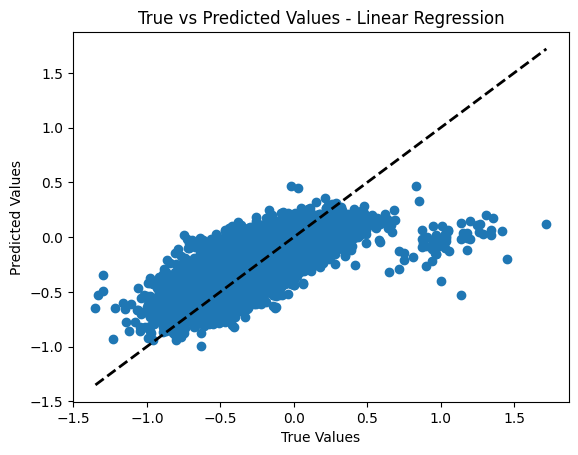

In [855]:
#Jordan

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

def train_linear_regression(X_train, Y_train, X_test, Y_test):
    # Initialize Linear Regression model
    model = LinearRegression()
    
    # Train the model on the training data
    model.fit(X_train, Y_train)
    
    # Cross-validation on the training set (using 5-fold)
    val_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    val_score_mean = np.mean(np.abs(val_scores))  # Mean of cross-validated scores

    # Predict on the test set
    y_pred_test = model.predict(X_test)
    test_score = mean_squared_error(Y_test, y_pred_test)

    # Calculate R-squared for test set
    r2_test = r2_score(Y_test, y_pred_test)

    # Print results
    print(f"Linear Regression - Val Score (MSE): {val_score_mean}, Test Score (MSE): {test_score}")
    print(f"Linear Regression - R² Test: {r2_test}")
    
    return model, val_score_mean, test_score, r2_test

# Example usage (use your actual datasets)
print("Training and Testing for CLFREE Reading using Linear Regression")
linear_model_clfree, val_score_clfree, test_score_clfree, r2_test_clfree = train_linear_regression(X_train_clfree, Y_train_clfree, X_test_clfree, Y_test_clfree)

# Optionally visualize the predictions vs actual values
def plot_predictions(Y_test, y_pred_test):
    plt.scatter(Y_test, y_pred_test)
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values - Linear Regression')
    plt.show()

# Plot for Linear Regression
y_pred_test_clfree = linear_model_clfree.predict(X_test_clfree)
plot_predictions(Y_test_clfree, y_pred_test_clfree)


In [863]:
#Ella

from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
 
def predict_with_vanilla_linear_reg(x_train,y_train, x_test, y_test):
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
 
    lr_r2_score = r2_score(y_test, y_pred)
    print(f"Vanilla Linear Regression R^2 Score: {lr_r2_score}")

    feature_names = x_train.columns if isinstance(x_train, pd.DataFrame) else [f"Feature_{i}" for i in range(x_train.shape[1])]
    
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": reg.coef_})
    print(coef_df)
    
    coef_df.to_csv('vanilla_lr_coefs.csv', index=False)
 
 
def scale_data(x_train, x_test):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled


predict_with_vanilla_linear_reg(X_train_clfree,Y_train_clfree, X_test_clfree, Y_test_clfree)

x_train_scaled, x_test_scaled = scale_data(X_train_clfree, X_test_clfree)

def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, data_copy):

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - Test MSE: {mse}")
    print(f"{model_name} - Test R^2 Score: {r2}")

    data_copy['predicted'] = np.nan
    data_copy.loc[X_test_clfree.index, 'predicted'] = y_pred
    data_copy.to_csv(f"'{model_name}_test_dataset.csv'", index=False)

    feature_names = x_train.columns if isinstance(x_train, pd.DataFrame) else [f"Feature_{i}" for i in range(x_train.shape[1])]

    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": model.coef_})
    print(coef_df)
    
    coef_df.to_csv(f"'{model_name}_lr_coefs.csv'", index=False)


lasso_model = Lasso(alpha=0.0001, max_iter=10000)
ridge_model = Ridge(alpha=0.2, max_iter=10000)
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)

# Train and evaluate each model individually
train_and_evaluate_model(lasso_model, 'Lasso', x_train_scaled, Y_train_clfree, x_test_scaled, Y_test_clfree, data_copy)
train_and_evaluate_model(ridge_model, 'Ridge', x_train_scaled, Y_train_clfree, x_test_scaled, Y_test_clfree, data_copy)
train_and_evaluate_model(elastic_net_model, 'ElasticNet', x_train_scaled, Y_train_clfree, x_test_scaled, Y_test_clfree, data_copy)

Vanilla Linear Regression R^2 Score: 0.5714172764285684
        Feature   Coefficient
0    FEEDERDIAM -3.086705e-05
1     FEEDERLEN -3.815830e-05
2       OUTLSZ1 -1.471746e-04
3       OUTLSZ2 -2.975539e-07
4       OUTLSZ3  1.063593e-04
..          ...           ...
88  WW220003993  0.000000e+00
89  WW220004000  0.000000e+00
90  WW220004037  0.000000e+00
91  WW260002590  0.000000e+00
92  WW260094120  0.000000e+00

[93 rows x 2 columns]
Lasso - Test MSE: 0.025852192530195144
Lasso - Test R^2 Score: 0.5715760666798118
Ridge - Test MSE: 0.025861609509567368
Ridge - Test R^2 Score: 0.571420007988158
ElasticNet - Test MSE: 0.036380910539704804
ElasticNet - Test R^2 Score: 0.39709358217933044


### Model 2: XGBoost

In [864]:
import xgboost as xgb

In [867]:
# Ella

%%time

param_grid = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [3, 5, 7],              
    'learning_rate': [0.01, 0.1, 0.2], 
}

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_clfree, Y_train_clfree)


best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

y_pred = best_model.predict(X_test_clfree)

data_copy['predicted'] = np.nan
data_copy.loc[X_test_clfree.index, 'predicted'] = y_pred
data_copy.to_csv('xbg_test_dataset.csv', index=False)

mse = mean_squared_error(Y_test_clfree, y_pred)
r2 = r2_score(Y_test_clfree, y_pred)
print(f"Best MSE: {mse}")
print(f"Best R^2: {r2}")

feature_importances = best_model.feature_importances_
print("Feature Importances:", feature_importances)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best MSE: 0.022319682357839474
Best R^2: 0.6301170163793988
Feature Importances: [0.00918407 0.00585893 0.00471586 0.00741382 0.         0.
 0.         0.         0.         0.         0.         0.01256246
 0.01168814 0.00788592 0.00539153 0.00751243 0.         0.01866363
 0.00182474 0.00821263 0.01174313 0.00206647 0.00822921 0.00943584
 0.         0.00594445 0.00565218 0.00772621 0.00684319 0.00511311
 0.00896407 0.01102252 0.0027394  0.00624238 0.00748777 0.00503081
 0.00227949 0.00510485 0.00593424 0.0067902  0.01411884 0.0148422
 0.01324808 0.00386599 0.01176909 0.00844986 0.01611422 0.00764918
 0.00620361 0.00672177 0.01001812 0.00913528 0.01004148 0.0275232
 0.00825174 0.00337627 0.02106606 0.         0.01458039 0.00817603
 0.00296958 0.00580514 0.0015288  0.00814305 0.01335078 0.01380115
 0.0064733  0.01222105 0.03092576 0.02100844 0

### Model 2: Ayan

### Model 3: Jordan

**Initial Model**: A RandomForestRegressor is created and trained using the training data. <br />
**Cross-Validation**: The model is evaluated using 5-fold cross-validation, which splits the training data into 5 subsets and trains the model on 4 subsets while validating it on the 5th. The average error (Mean Squared Error) is calculated. <br />
**Test Set Evaluation**: After cross-validation, the model's performance is evaluated on the test set using Mean Squared Error (MSE). <br />
**Hyperparameter Tuning**: RandomizedSearchCV is used to search over a set of hyperparameters (e.g., number of trees, depth of trees, etc.) and find the best combination that minimizes the error.<br />
**Best Model Evaluation**: Once the best model is found, it’s re-evaluated on the training set with cross-validation and on the test set to calculate the final validation and test scores. 

In [710]:
def train_and_tune_model(X_train, Y_train, X_test, Y_test):
    print("Training the initial model...")
    
    # Initial model training with default parameters
    model = RandomForestRegressor()
    model.fit(X_train, Y_train)
    
    # Cross-validation on the training set
    print("Performing cross-validation on the initial model...")
    val_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    val_score_mean = np.mean(np.abs(val_scores))
    print(f"Initial Cross-Validation Scores (MSE): {val_scores}")
    print(f"Initial Validation Mean Score (MSE): {val_score_mean}")

    r2_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='r2')
    r2_mean = np.mean(r2_scores)
    print(f"Initial Cross-Validation Scores (R2): {r2_scores}")
    print(f"Initial Validation Mean Score (R2): {r2_mean}")

    # Calculate test set score
    y_pred_test = model.predict(X_test)
    test_score = mean_squared_error(Y_test, y_pred_test)
    print(f"Initial Test Score (MSE): {test_score}")

    test_r2 = r2_score(Y_test, y_pred_test)
    print(f"Initial Test Score (R2): {test_r2}")

    # Hyperparameter tuning using RandomizedSearchCV
#     print("Starting hyperparameter tuning with RandomizedSearchCV...")
#     param_distributions = {
#         'n_estimators': [100, 200],
#         'max_depth': [None, 10],
#         'min_samples_split': [2, 5],
#         'min_samples_leaf': [1, 2],
#         'bootstrap': [True, False]
#     }
    
#     random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
#                                        n_iter=5, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

#     # Fitting the randomized search
#     random_search.fit(X_train, Y_train)
#     print("Hyperparameter tuning complete.")
    
#     # Best model after tuning
#     best_model = random_search.best_estimator_
#     print(f"Best parameters found: {random_search.best_params_}")

#     # Cross-validation for the best model
#     print("Performing cross-validation for the best model...")
#     best_val_scores = cross_val_score(best_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
#     best_val_score_mean = np.mean(np.abs(best_val_scores))
#     print(f"Best Model Cross-Validation Scores (MSE): {best_val_scores}")
#     print(f"Best Model Validation Mean Score (MSE): {best_val_score_mean}")

#     # Evaluate the best model on the test set
#     y_pred_best = best_model.predict(X_test)
#     best_test_score = mean_squared_error(Y_test, y_pred_best)
#     print(f"Best Model Test Score (MSE): {best_test_score}")
    
#     return best_model, best_val_score_mean, best_test_score

# # Train and evaluate the model
# print("Training and Testing for CLFREE Reading")
# best_model_clfree, val_score_clfree, test_score_clfree = train_and_tune_model(X_train_clfree, Y_train_clfree, X_test_clfree, Y_test_clfree)


train_and_tune_model(X_train_clfree,Y_train_clfree, X_test_clfree, Y_test_clfree) 

Training the initial model...
Performing cross-validation on the initial model...
Initial Cross-Validation Scores (MSE): [-0.02775565 -0.02351622 -0.02421502 -0.02369182 -0.02479493]
Initial Validation Mean Score (MSE): 0.024794727396309797
Initial Cross-Validation Scores (R2): [0.56764668 0.59917923 0.60099287 0.60430438 0.60333375]
Initial Validation Mean Score (R2): 0.5950913812377319
Initial Test Score (MSE): 0.023857106129081325
Initial Test Score (R2): 0.6046387464614383


# Result Comparison

# Testing the Model